# SENTIMENT ANALYSIS 

Fuente: alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad


Para entrenar el modelo de análisis de sentimiento, se utilizará el algoritmo Naive Bayes. Este algoritmo es adecuado para problemas de clasificación de texto y se basa en el teorema de Bayes para hacer predicciones. Tomaremos como conjunto de prueba el 30% de los datos del dataset "train". El dataset "test" lo usaremos para realizar predicciones como datos de producción.

In [146]:
#LIBRERIAS

from datasets import load_dataset
import tqdm as notebook_tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


### ENTRENAMIENTO DE MODELO DE ANALISIS DE SENTIMIENTOS

In [147]:
## DATA SOURCE (DATASETS)

full_train_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")

### Reduciendo el número de las muestras por efectos de capacidad de cómputo (10% de la data original)
train_dataset = full_train_dataset.shuffle(seed=42)
train_dataset = pd.DataFrame(train_dataset).dropna().sample(frac=1, random_state=42).reset_index(drop=True)
train_dataset.head(5)
print(len(train_dataset))
train_dataset["Largo"] = train_dataset["text"].apply(len)

176192


In [148]:
train_dataset.head(5).sort_values(by=['Largo'], ascending=False)

,text,label,Largo
1,aquí todo lo que brilla es oro. considerada po...,5,441
3,debe visitar. los imponentes en forma de obeli...,5,439
0,"un hotel para disfrutar en pareja. divino,un h...",5,337
4,recomendado siempre. la energía en este lugar ...,5,140
2,obispado. si te quieres deleitar con una hermo...,3,136


In [149]:
### RECLASIFICACIÓN DE SENTIMIENTOS Y VECTORIZACIÓN (TRAIN) ###   

def reclasificar_sentimiento(valor):
    if valor <= 2:
        return "Negative"
    elif valor == 3:
        return "Neutral"
    else:
        return "Positive"

# Aplicar la reclasificación
train_dataset['s'] = train_dataset['label'].apply(reclasificar_sentimiento)

nltk.download('stopwords', quiet=True)
spanish_stopwords = stopwords.words('spanish')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words=spanish_stopwords, max_features=200, ngram_range=(1,2), tokenizer=token.tokenize)
text_counts_train = cv.fit_transform(train_dataset.text)

print("Shape after filtering:", train_dataset.shape)
train_dataset.head(10)


c:\Users\joey_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\joey_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'an', 'as', 'bamos', 'est', 'estuvi', 'fu', 'hab', 'habr', 'hubi', 'is', 'l', 'm', 'n', 'qu', 'ramos', 's', 'semos', 'ser', 't', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  warnings.warn(


Shape after filtering: (176192, 4)


,text,label,Largo,s
0,"un hotel para disfrutar en pareja. divino,un h...",5,337,Positive
1,aquí todo lo que brilla es oro. considerada po...,5,441,Positive
2,obispado. si te quieres deleitar con una hermo...,3,136,Neutral
3,debe visitar. los imponentes en forma de obeli...,5,439,Positive
4,recomendado siempre. la energía en este lugar ...,5,140,Positive
5,comodidad normal. el sistema de clima queda a ...,3,334,Neutral
6,"excelente atencion. estancia muy placentera, m...",5,244,Positive
7,recomendado. sitio típico con fotos de ernest ...,5,177,Positive
8,pechuga de pato sobre cocida. el servicio fue ...,3,332,Neutral
9,el mejor hotel de todo incluido. reservé este ...,5,928,Positive


In [150]:
### SPLITEO DE LOS DATOS EN TRAIN Y TEST ###

X_train, X_test, y_train, y_test = train_test_split(
    text_counts_train, train_dataset['s'], test_size=0.3, random_state=42)

In [151]:
### ENTRENAMIENTO DEL MODELO ###

# Definir el rango de valores para alpha
param_grid = {'alpha': [0.05, 0.1, 0.5, 1.0]}

# Configurar la búsqueda en rejilla con validación cruzada
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Seleccionar el mejor estimador encontrado
clf = grid_search.best_estimator_

# Realizar predicciones y mostrar resultados
predicted = clf.predict(X_test)
print("Mejor alpha:", grid_search.best_params_['alpha'])
print("MultinomialNB Accuracy optimizado:", round(metrics.accuracy_score(y_test, predicted), 4))

Mejor alpha: 0.05
MultinomialNB Accuracy optimizado: 0.8374


<Figure size 1000x600 with 0 Axes>

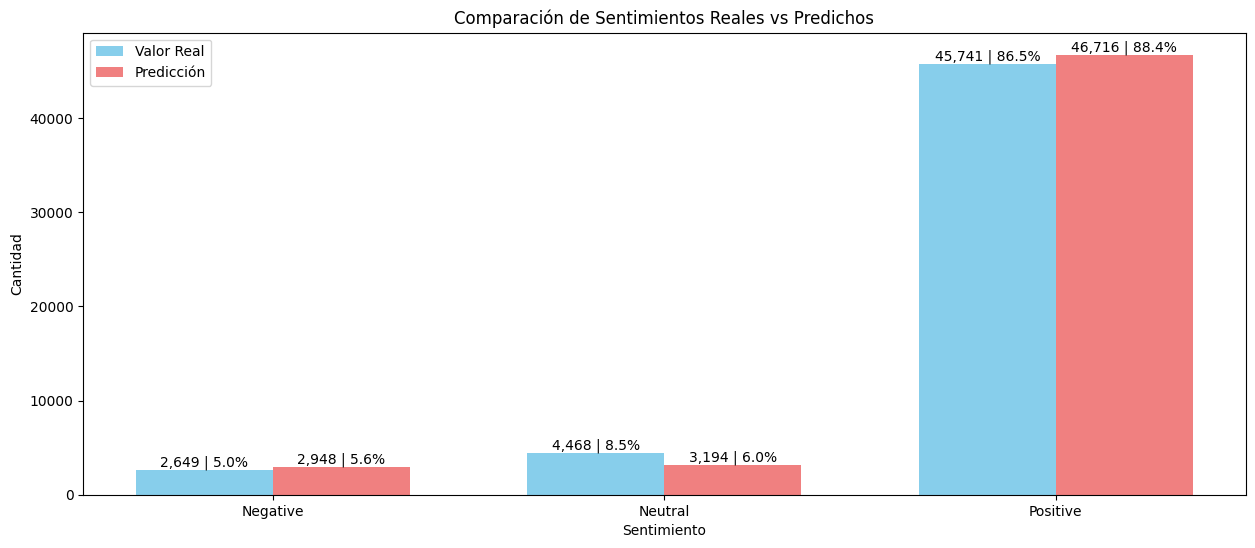


Comparación de predicciones vs valores reales:
       Valor Real Predicción
127679   Positive   Positive
8284     Positive   Positive
125010   Positive   Negative
31684    Positive   Positive
162078    Neutral   Positive
...           ...        ...
47529    Positive   Positive
76001    Positive   Positive
103561   Positive   Positive
152655   Positive   Positive
104978   Positive   Positive

[52858 rows x 2 columns]


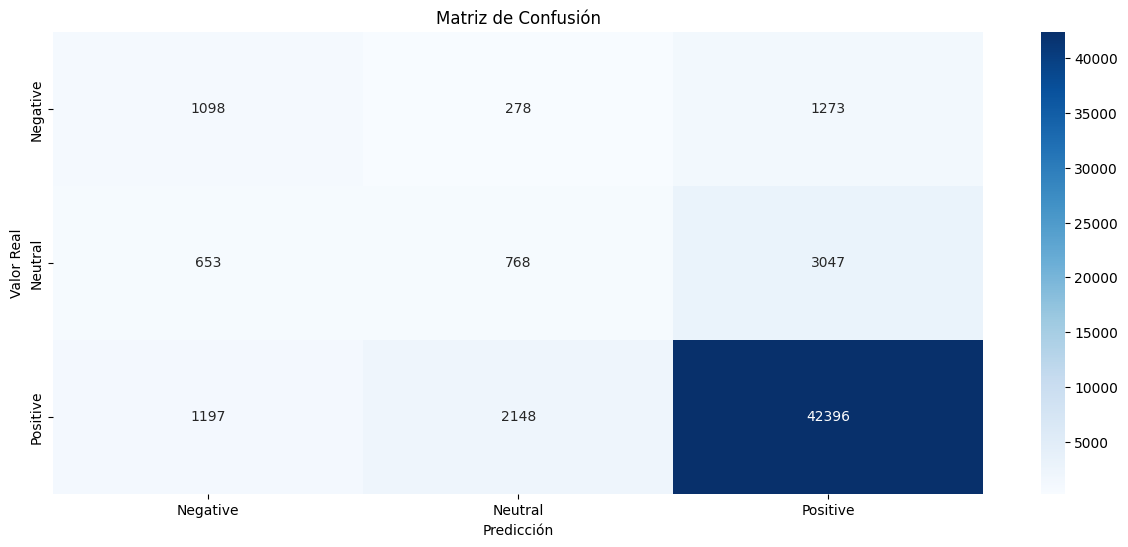

In [152]:
### VISUALIZACIÓN DE RESULTADOS ###

# Create a DataFrame with the comparison
comparison_df = pd.DataFrame({
    'Valor Real': y_test,
    'Predicción': predicted
})

# Create bar chart comparing real vs predicted
plt.figure(figsize=(10, 6))
real_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(predicted).value_counts().sort_index()

# Calculate percentages
real_percentages = (real_counts / real_counts.sum()) * 100
pred_percentages = (pred_counts / pred_counts.sum()) * 100

x = np.arange(len(real_counts))
width = 0.35

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(15, 6))
# Create bars
bars1 = plt.bar(x - width/2, real_counts, width, label='Valor Real', color='skyblue')
bars2 = plt.bar(x + width/2, pred_counts, width, label='Predicción', color='lightcoral')

# Add percentage labels on top of each bar
for bars in [bars1, bars2]:
    for idx, rect in enumerate(bars):
        height = rect.get_height()
        percentage = real_percentages[idx] if bars == bars1 else pred_percentages[idx]
        count = real_counts[idx] if bars == bars1 else pred_counts[idx]
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{count:,.0f} | {percentage:.1f}%',
                ha='center', va='bottom')

plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Comparación de Sentimientos Reales vs Predichos')
plt.xticks(x, sentiment_labels)
plt.legend()
plt.show()

# Display the comparison DataFrame
print("\nComparación de predicciones vs valores reales:")
print(comparison_df)

# Optional: Create a confusion matrix visualization
plt.figure(figsize=(15, 6))
confusion_matrix = pd.crosstab(comparison_df['Valor Real'], comparison_df['Predicción'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

## SIMULACIÓN DE DATOS DE PRODUCCIÓN (PREDICCIONES)

In [153]:
## DATA SOURCE (DATASETS)

full_produccion_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="test")

### Reduciendo el número de las muestras por efectos de capacidad de cómputo (10% de la data original)
produccion_dataset = full_produccion_dataset.shuffle(seed=42)
produccion_dataset = pd.DataFrame(produccion_dataset).dropna().sample(frac=1, random_state=42).reset_index(drop=True)
produccion_dataset.head(5)
print(len(produccion_dataset))
produccion_dataset["Largo"] = produccion_dataset["text"].apply(len)

75510


In [154]:
### PREDICCIÓN DE SENTIMIENTOS EN PRODUCCIÓN ###

# Vectorizar los comentarios de producción utilizando el vectorizador 'cv'
production_text_counts = cv.transform(produccion_dataset['text'])

# Realizar predicciones utilizando el modelo 'clf'
production_predictions = clf.predict(production_text_counts)

# Agregar las predicciones al dataframe original
produccion_dataset['predicted_sentiment'] = production_predictions

produccion_dataset.head(10)


,text,label,Largo,predicted_sentiment
0,"linda, romántica y llena de historia . una lin...",5,321,Positive
1,las mejores vacaciones en cartagena plaza. que...,5,244,Positive
2,"excelente. imponente edificacion, digna del si...",5,519,Positive
3,magnifico. primero reconocer que en mi visita ...,5,273,Positive
4,muy viejo. ... agitada plaza.. me encantó. bue...,5,316,Positive
5,gran ciudad maya. lo que más me impresionó de ...,5,442,Neutral
6,"debe ser aquí mañana.. si puedes, alquilar un ...",5,180,Positive
7,merece la pena dar un paseo. un montón de impr...,5,167,Positive
8,lo mejor. hace 22 años vine con mis padres de ...,5,327,Positive
9,"bellìsima ciudad, en un entorno muy bien cuida...",5,403,Positive


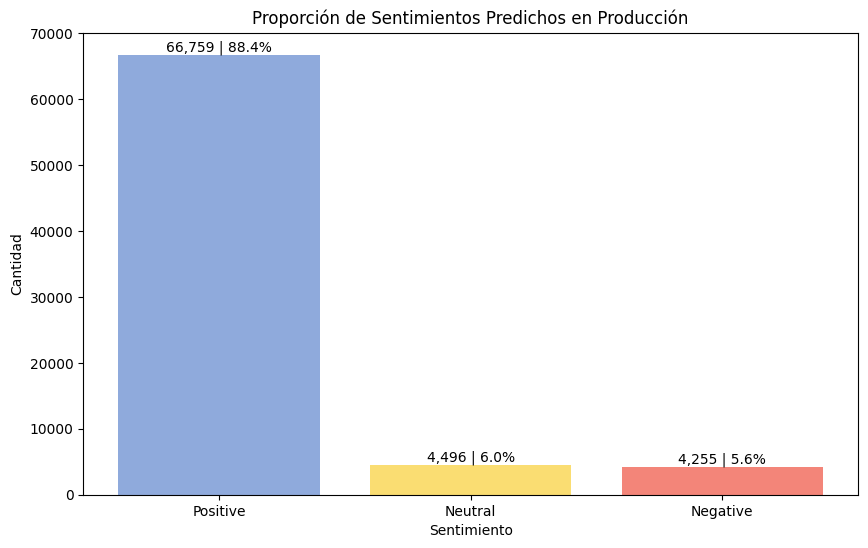

In [155]:

### VISUALIZACIÓN DE RESULTADOS EN PRODUCCIÓN ###

# Definir colores para cada sentimiento
sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}

# Crear un gráfico de barras para las proporciones de sentimientos
plt.figure(figsize=(10, 6))
# Calculate the counts of each predicted sentiment
production_sentiment_counts = produccion_dataset['predicted_sentiment'].value_counts()

# Create the bar plot
production_bars = plt.bar(
    production_sentiment_counts.index,
    production_sentiment_counts,
    color=[sentiment_colors[sentiment] for sentiment in production_sentiment_counts.index]
)

# Add percentage labels on top of each bar
for rect in production_bars:
    height = rect.get_height()
    percentage = (height / production_sentiment_counts.sum()) * 100
    plt.text(rect.get_x() + rect.get_width()/2., height,
             f'{height:,.0f} | {percentage:.1f}%',
             ha='center', va='bottom')

plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Proporción de Sentimientos Predichos en Producción')
plt.xticks(production_sentiment_counts.index, production_sentiment_counts.index)
plt.show()




Los valores esperados para el conjunto de producción son los siguientes: Positivos (86.4%), Neutrales (8.5%) y Negativos (5.1%). Tomándose en cuenta que la precisión del modelo es de 83.7% y se puede concluir que el modelo es adecuado para predecir los valores esperados del conjunto de producción.

### ANÁLISIS DE TÓPICOS PRINCIPALES EN LOS COMENTARIOS DE LOS CLIENTES

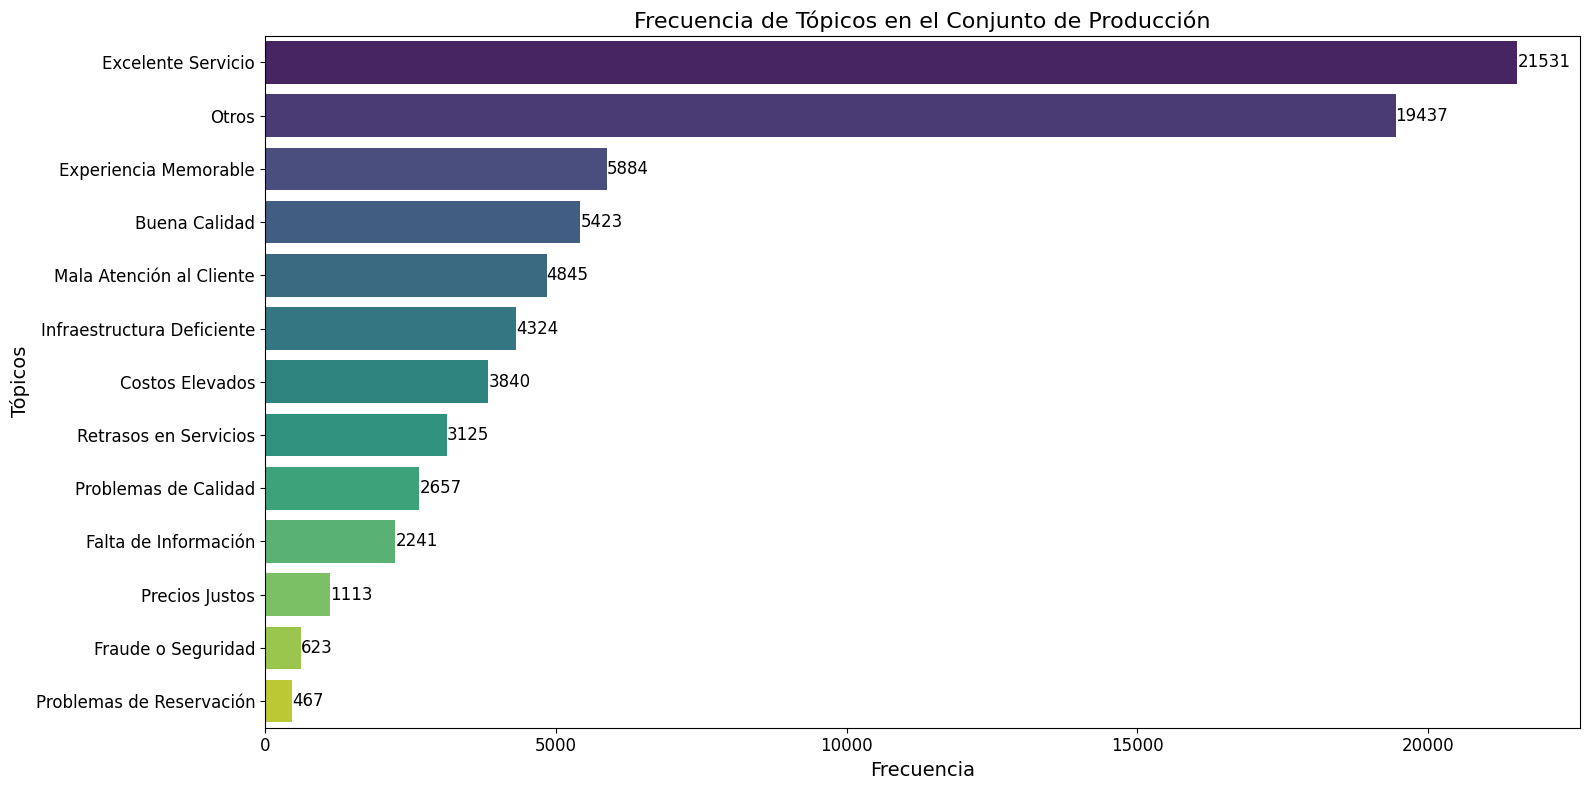

In [156]:

lemmatizer = WordNetLemmatizer()

# Definición de los problemas predefinidos (Estos son solo ejemplos, se pueden agregar más problemas y palabras clave si es necesario para entrenar el modelo)
predefined_issues = {
    "Retrasos en Servicios": ["lento", "tardado", "espera", "demora", "llegar", "retraso"],
    "Mala Atención al Cliente": ["grosero", "mala", "atención", "ayuda", "incompetente", "amable"],
    "Problemas de Calidad": ["sucio", "malo", "suciedad", "calidad", "pésimo", "roto"],
    "Fraude o Seguridad": ["estafa", "fraude", "seguridad", "confianza", "engaño", "robo"],
    "Costos Elevados": ["caro", "precio", "costoso", "dinero", "pagar", "tarifa"],
    "Infraestructura Deficiente": ["instalaciones", "baño", "habitación", "sucio", "mantenimiento", "roto"],
    "Falta de Información": ["información", "comunicación", "respuesta", "contestar", "claro", "duda"],
    "Problemas de Reservación": ["reserva", "cancelar", "booking", "disponible", "error", "confirmación"],
    "Excelente Servicio": ["excelente", "rápido", "amable", "servicio", "atención", "genial"],
    "Buena Calidad": ["limpio", "bonito", "calidad", "cómodo", "agradable", "perfecto"],
    "Precios Justos": ["barato", "justo", "precio", "económico", "accesible", "valor"],
    "Experiencia Memorable": ["inolvidable", "maravilloso", "hermoso", "disfrutar", "fantástico", "recomiendo"]
}

# Función para lematizar el texto
def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

# Función para asignar un problema basado en el comentario
def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Otros"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap:
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Otros"

# Supongamos que 'produccion_dataset_nn' es el DataFrame de producción filtrado por sentimientos neutrales y negativos
produccion_dataset['issue'] = produccion_dataset["text"].apply(assign_issue)

# Visualización de la clasificación de tópicos
plt.figure(figsize=(16, 8))
issue_counts = produccion_dataset['issue'].value_counts()
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette="viridis", hue=issue_counts.index)
plt.xlabel('Frecuencia', size=14)
plt.ylabel('Tópicos', size=14)
plt.title('Frecuencia de Tópicos en el Conjunto de Producción', size=16)
for i, v in enumerate(issue_counts.values):
    plt.text(v, i, str(v), va='center', size=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()




### ANÁLISIS DE TÓPICOS PARA COMENTARIOS NEGATIVOS Y NEUTRALES

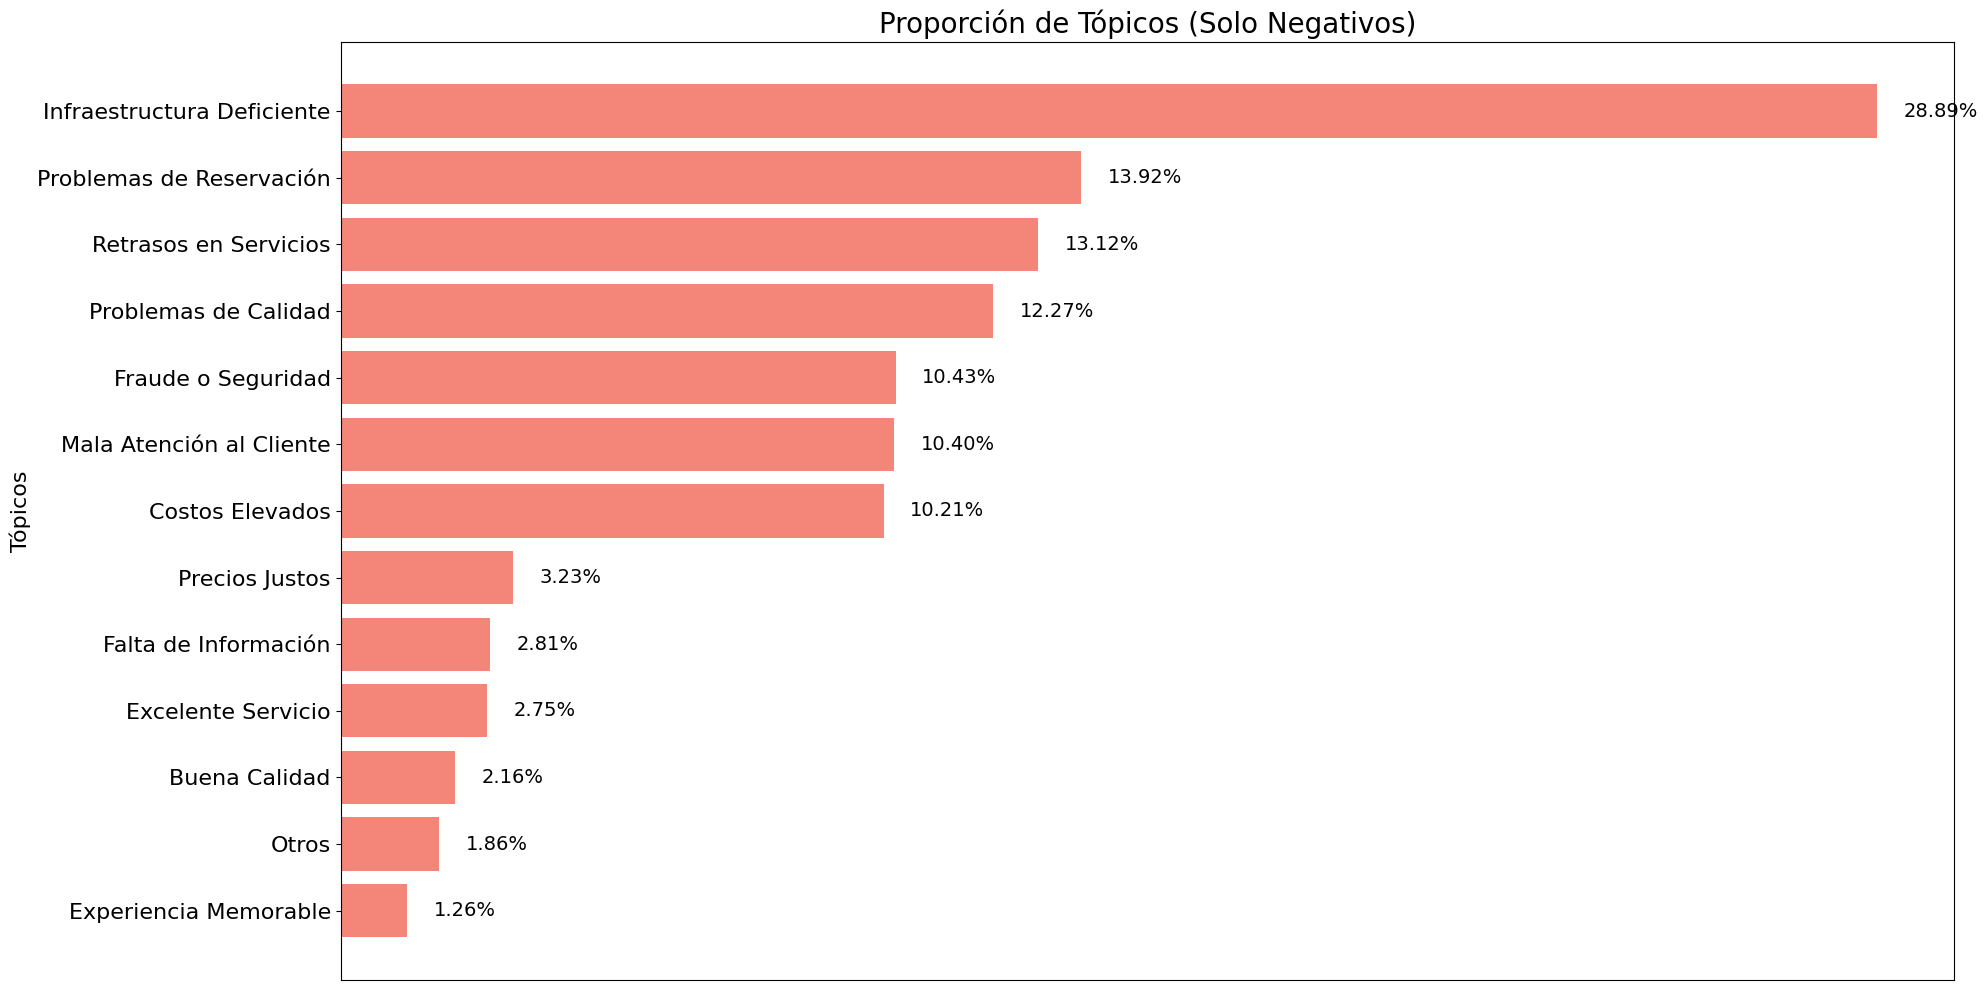

In [157]:
# Extraer y ordenar las proporciones negativas
negative_proportions = issue_sentiment_proportions['Negative'].sort_values(ascending=True)

plt.figure(figsize=(20, 10))
bars = plt.barh(negative_proportions.index, negative_proportions.values, color=sentiment_colors['Negative'])

# Agregar etiquetas con el porcentaje
for i, value in enumerate(negative_proportions.values):
    plt.text(value + 0.005, i, f"{value:.2%}", va='center', fontsize=14)

plt.ylabel('Tópicos', size=16)
plt.title('Proporción de Tópicos (Solo Negativos)', size=20)
plt.gca().get_xaxis().set_visible(False)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


In [158]:
### produccion_dataset.to_excel('produccion_dataset.xlsx', index=False)